In [28]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import sharedstreets.tile
import mercantile
from shapely.geometry import Point, shape, MultiPoint
from functools import partial
import pyproj
from shapely.ops import transform, nearest_points

# download the street map from OSM

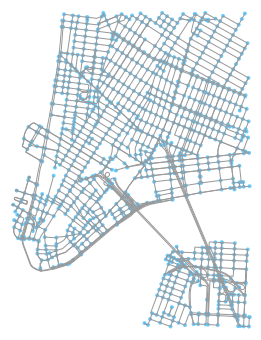

(<Figure size 432.121x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x240c5550>)

In [85]:
G = ox.graph_from_point((40.712800, -74.006000), distance=2000, network_type='drive')
ox.plot_graph(G)

In [86]:
# save network as shapefile, two one-way links will be merged as one two-way link
# will help in runtime
ox.save_graph_shapefile(G, filename='network-shape_nyc')

In [87]:
# read shapefile as geopandas df
osm_edges_gdf = gpd.read_file("data/network-shape_nyc/edges/edges.shp")
osm_edges_gdf['mid_point'] = osm_edges_gdf['geometry'].interpolate(0.5, normalized = True)
osm_edges_gdf.shape

(1975, 17)

#convert netwrokx directly to geopandas
#this keeps two-ways streets as two one-way links
osm_nodes_gdf = ox.graph_to_gdfs(G, nodes = True, edges = False)
osm_edges_gdf = ox.graph_to_gdfs(G, nodes = False, edges = True)
osm_edges_gdf['mid_point'] = osm_edges_gdf['geometry'].interpolate(0.5, normalized = True)

#networkx can convert to pandas df
nx.to_pandas_edgelist(G).head(3)

# Getting SharedStreets

In [88]:
# generate a GeoJSON which represents the parsed protobuf vector tiles from SharedStreets, 
# representing all tiles related to the networkx

def generate_geojson_of_coverage_area_streets(G, z=12, buffer_size = 0.015):
    geojson_master = None
    for mt in _generate_tile_coordinates(G, z, buffer_size):
        tile = sharedstreets.tile.get_tile(z, mt.x, mt.y)
        geojson = sharedstreets.tile.make_geojson(tile)

        if geojson_master is None:
            geojson_master = geojson

        else:
            # Updates both the features and references keys
            for key in ['features', 'references']:
                fs = _filter_new_objects(geojson_master, geojson, key)
                geojson_master[key].extend(fs)
    return geojson_master



def _generate_tile_coordinates(G, z, buffer_size = 0.015):
    '''
    :G: is either a networkX graph instance or a tuple of lat/long
    :z: is zoom level. Default is 12
    :buffer_size: is in degrees. Default: 0.015 is approx 1 mile, 0.03 is about 2 miles
    # parts of this are from http://kuanbutts.com/2018/06/07/sharedstreets-explore/
    # convert lat-long to XYZ tiles, use mercantile, https://media.readthedocs.org/pdf/mercantile/latest/mercantile.pdf
    '''
    mts = []
    for i, n in list(G.nodes(data=True)):
        # Now perform a buffer around the node points
        # to get a rough estimate of everything within
        # about 1 miles of the node
        p = Point(n['x'], n['y'])
        bp = p.buffer(buffer_size)  
        bpe = bp.simplify(0.005).exterior
        for x, y in zip(*bpe.coords.xy):
            mt = mercantile.tile(x, y, z)
            mts.append(mt)

    # Dedupe results
    return set(mts)


def _filter_new_objects(master, new_gj, key):
    keep = []
    gm_ids = [f['id'] for f in master[key]]
    for f2 in new_gj[key]:
        if f2['id'] not in gm_ids:
            keep.append(f2)
    return keep

In [89]:
# Generate a GeoJSON Feature Collection of the total coverage area, 1hr to run for the Met Council Core region
ssgj = generate_geojson_of_coverage_area_streets(G)

# Tag SSID to existing OSM graph

In [90]:
# creating a look up from the reference to the geometries
geometry_lookup = {}
for feature in ssgj['features']:
    i = feature['id']
    geometry_lookup[i] = feature
    
shaped_references = []
for r in ssgj['references']:
    feature = geometry_lookup[r['geometryId']]
    r['feature'] = feature
    
    # Also convert all distances to meter from centimeter
    for lr in r['locationReferences']:
        d = lr['distanceToNextRef']
        if d is not None:
            lr['distanceToNextRef'] = d/100.0

    shaped_references.append(r)

In [92]:
# Create the edges dataframe
ss_edges = []
for sr in shaped_references:
    # Only do for direct edges (which should be all)
    if len(sr['locationReferences']) == 2:
        lrs = sr['locationReferences']
        if lrs[0]['sequence'] == 0:
            first = 0
            last = 1
        else:
            first = 1
            last = 0
            
        lrs = sr['locationReferences']
        fr = lrs[first]['intersectionId']
        to = lrs[last]['intersectionId']
        d = lrs[first]['distanceToNextRef']
        ss_edges.append({
            'id': sr['id'],
            'from': fr,
            'to': to,
            'length': d,
            'geometry': shape(sr['feature']['geometry'])
        })

    # This should not ever happen
    else:
        # Could actually use logger instead of a print statement
        print('Skipped an edge - not length 2')
        
ss_edges_df = pd.DataFrame(ss_edges)
ss_edges_df = ss_edges_df.drop_duplicates(subset=['id'], keep='first')
ss_edges_gdf = gpd.GeoDataFrame(ss_edges_df, geometry=ss_edges_df.geometry)

ss_edges_gdf['mid_point'] = ss_edges_gdf['geometry'].interpolate(0.5, normalized = True)
ss_edges_gdf.shape

(27117, 6)

In [93]:
def nearest(row, geom_union, df1, df2, geom1_col, geom2_col, src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].get_values()[0]
    return value

In [94]:
#unary_union = ss_edges_gdf['mid_point'].unary_union
unary_union = MultiPoint(ss_edges_gdf['mid_point'])
type(unary_union)

shapely.geometry.multipoint.MultiPoint

In [95]:
osm_edges_gdf['ss_id'] = osm_edges_gdf.apply(nearest, 
                                        geom_union = unary_union, 
                                        df1 = osm_edges_gdf, 
                                        df2 = ss_edges_gdf, 
                                        geom1_col = 'mid_point', 
                                        geom2_col = 'mid_point',
                                        src_column='id', 
                                        axis=1)

In [96]:
ss_assoc_gdf = ss_edges_gdf[ss_edges_gdf['id'].isin(osm_edges_gdf['ss_id'])]

In [106]:
type(ss_assoc_gdf)

geopandas.geodataframe.GeoDataFrame

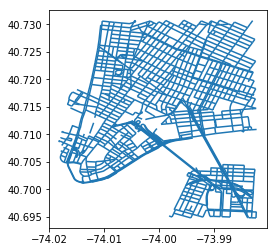

In [107]:
ss_assoc_gdf.plot()

In [68]:
ss_assoc_gdf[ss_assoc_gdf['nearest_id'].isin([#'4bea9e1e75f9e14d33e26950044531b9',
                                             #'7b4984888cbce6814ac4906d269c74b8',
                                              '322666f63973ce39b9bcfecb1981941e'])]

,nearest_id,ss_mid_point,ss_geom,geometry
15,322666f63973ce39b9bcfecb1981941e,POINT (-74.00461325000001 40.71374655),"LINESTRING (-74.0048235 40.7134886, -74.004403...","LINESTRING (-74.0048235 40.7134886, -74.004403..."
30,322666f63973ce39b9bcfecb1981941e,POINT (-74.00461325000001 40.71374655),"LINESTRING (-74.0048235 40.7134886, -74.004403...","LINESTRING (-74.0048235 40.7134886, -74.004403..."


In [69]:
osm_edges_gdf[osm_edges_gdf['nearest_id'] == '322666f63973ce39b9bcfecb1981941e']

,bridge,from,highway,key,lanes,length,maxspeed,name,oneway,osmid,to,tunnel,geometry,mid_point,nearest_id,ss_geom,ss_mid_point
15,None,42431602,residential,0,None,67.431,25 mph,Elk Street,True,5671121,42443588,None,"LINESTRING (-74.0048235 40.7134886, -74.004702...",POINT (-74.00461323557934 40.71374653824885),322666f63973ce39b9bcfecb1981941e,"LINESTRING (-74.0048235 40.7134886, -74.004403...",POINT (-74.00461325000001 40.71374655)
30,None,4878831008,residential,0,None,75.48599999999999,25 mph,Chambers Street,False,275016228,42431602,None,"LINESTRING (-74.004059 40.713135, -74.0041891 ...",POINT (-74.00444180953026 40.71331057003469),322666f63973ce39b9bcfecb1981941e,"LINESTRING (-74.0048235 40.7134886, -74.004403...",POINT (-74.00461325000001 40.71374655)


In [49]:
osm_edges_gdf[osm_edges_gdf['name'] == 'Chambers Street']

,bridge,from,highway,key,lanes,length,maxspeed,name,oneway,osmid,to,tunnel,geometry,mid_point,nearest_id,ss_geom
29,None,272195271,residential,0,None,146.181,25 mph,Chambers Street,False,275016228,42431602,None,"LINESTRING (-74.00630409999999 40.7141733, -74...",POINT (-74.00556380491672 40.71383093937111),7b4984888cbce6814ac4906d269c74b8,"LINESTRING (-74.0048235 40.7134886, -74.006198..."
30,None,4878831008,residential,0,None,75.48599999999999,25 mph,Chambers Street,False,275016228,42431602,None,"LINESTRING (-74.004059 40.713135, -74.0041891 ...",POINT (-74.00444180953026 40.71331057003469),322666f63973ce39b9bcfecb1981941e,"LINESTRING (-74.0048235 40.7134886, -74.004403..."
31,None,272195271,residential,0,None,162.696,25 mph,Chambers Street,False,275016228,42431611,None,"LINESTRING (-74.00630409999999 40.7141733, -74...",POINT (-74.00712809999999 40.71455425),4bea9e1e75f9e14d33e26950044531b9,"LINESTRING (-74.00630409999999 40.7141733, -74..."
